# Florence-2-large sample usage

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install flash_attn einops timm

Note: you may need to restart the kernel to use updated packages.


In [3]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
%matplotlib inline  

In [4]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True,cache_dir='./models/').eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True,cache_dir='./models/')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## define the prediction function

In [5]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image 

In [6]:
#url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
#image = Image.open(requests.get(url, stream=True).raw)

In [32]:
image = Image.open('./data/IMG_0194.JPG')

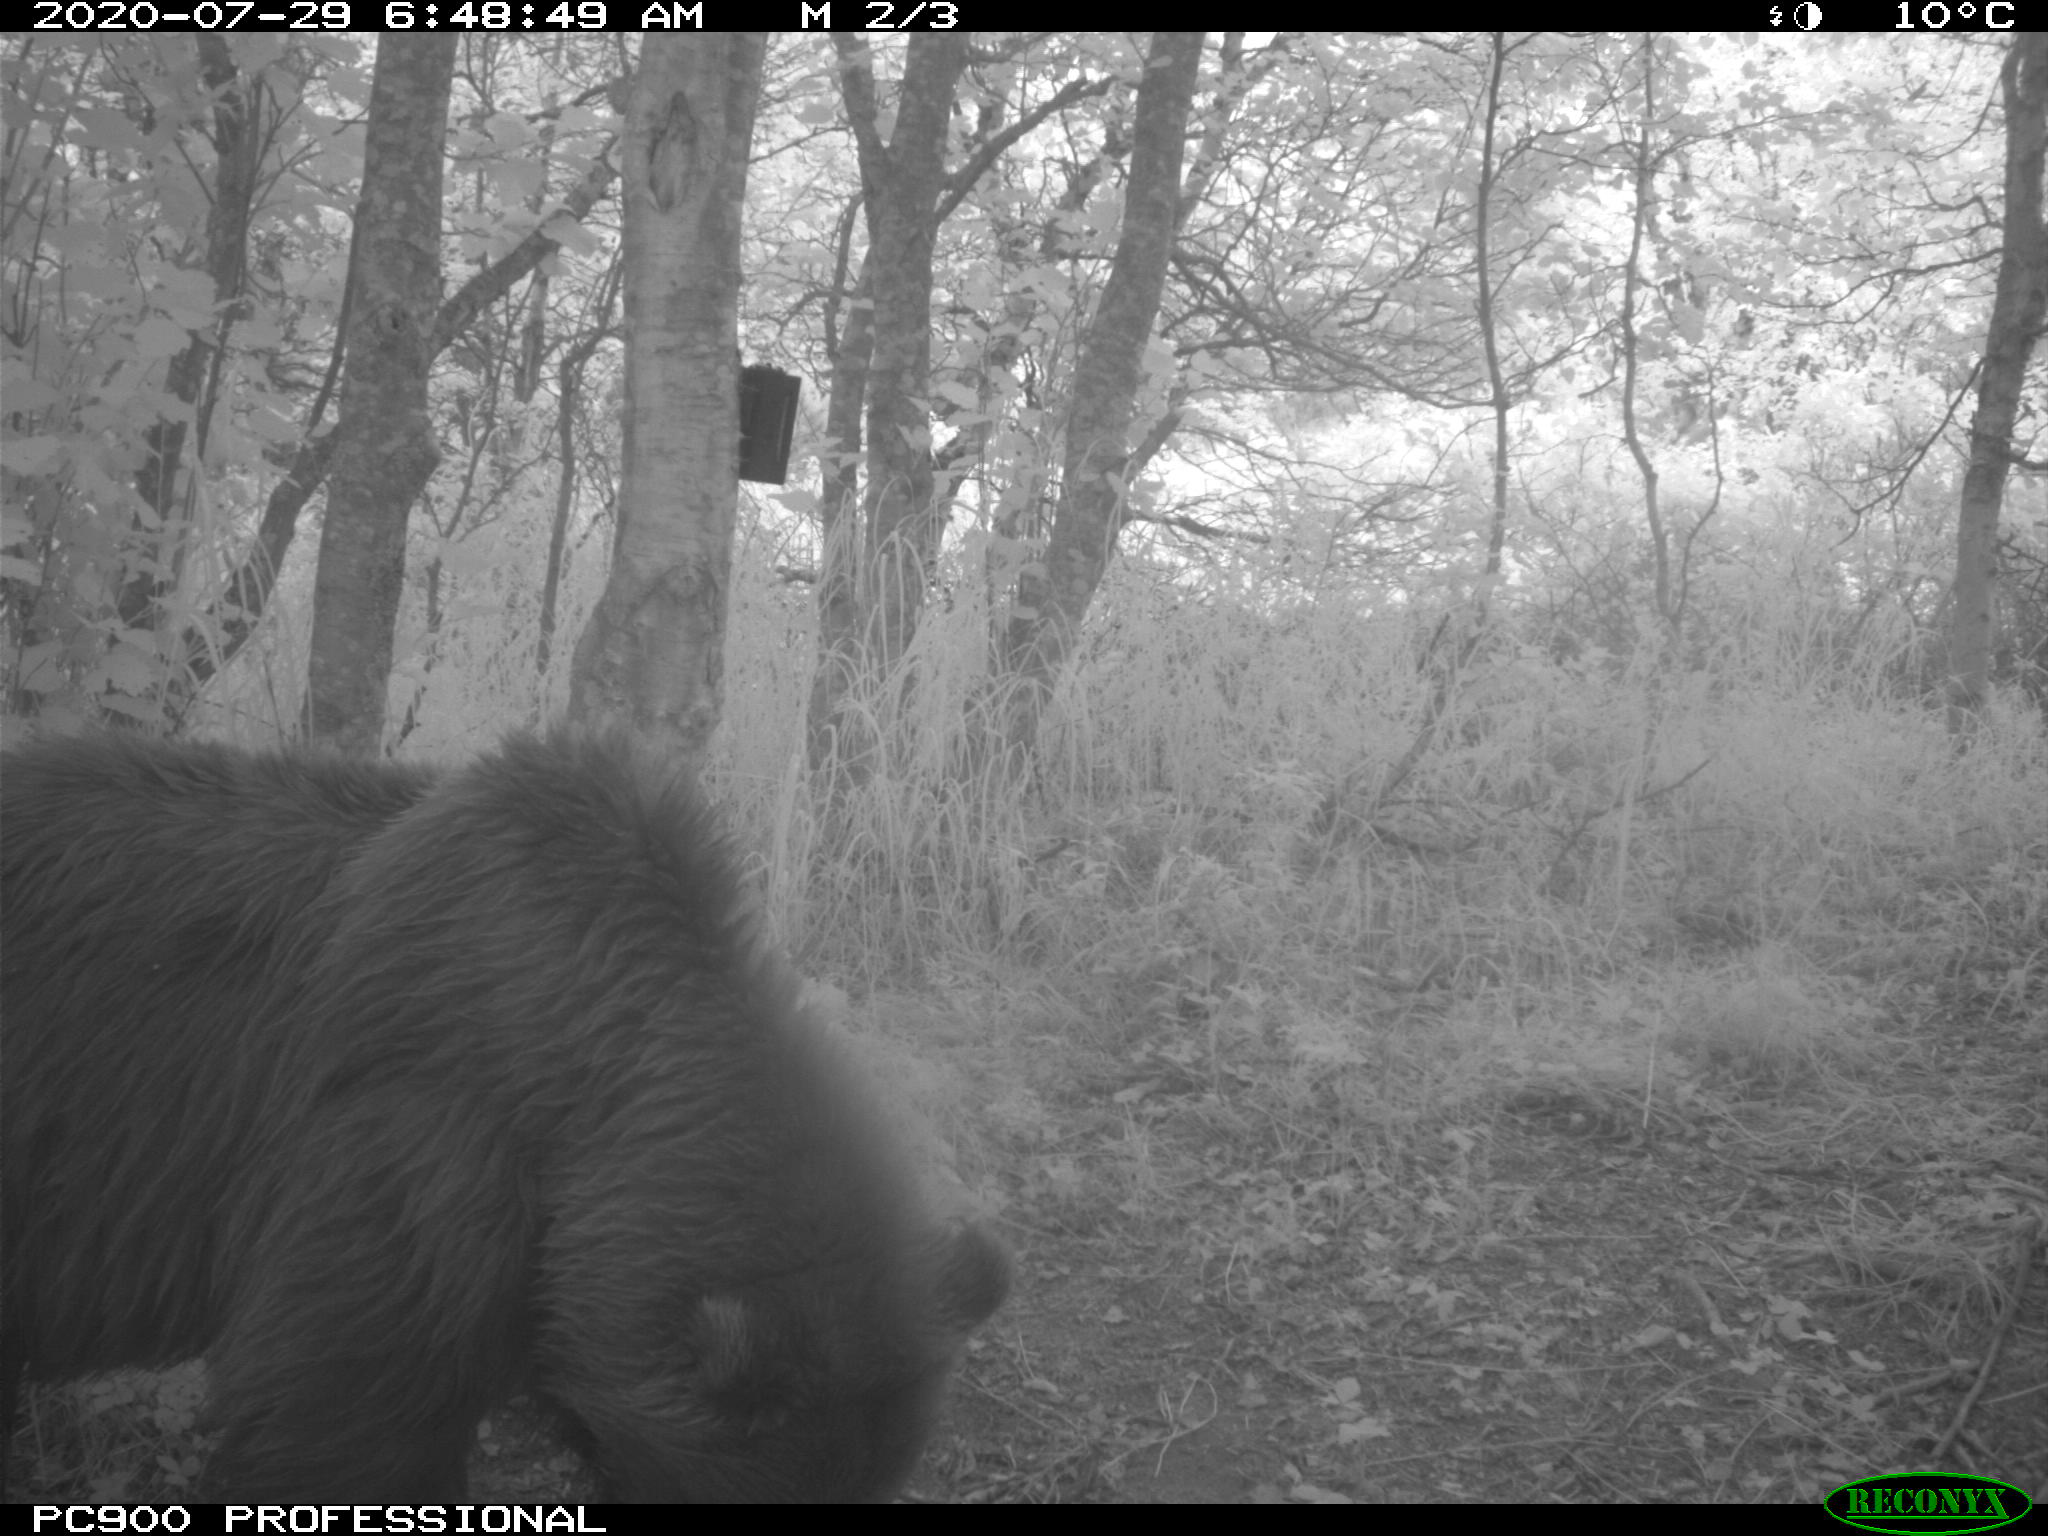

In [33]:
image

In [34]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

In [35]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[1.0240000486373901, 718.0800170898438, 1022.97607421875, 1510.656005859375]], 'labels': ['grizzly bear in wooded area']}}


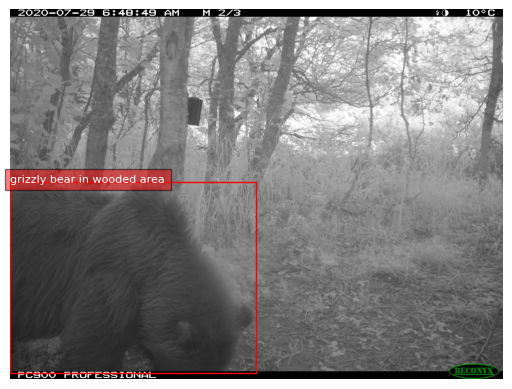

In [36]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])